# Features Selection: Scikit Learn

Collection of features selection techniques provided by Scikit Learn:

In [4]:
%matplotlib inline
import sys
sys.path.append('../../')  
from tools.reader import csv2df as reader, get_dcol
from preprocessing.preparation import full as preprocess
from preprocessing.scalers import normalization
from tools.columns import num2cal
from models.metrics import metrics_regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy

### arguments

In [5]:
path_input = '../../../datasets/dataset.solar.csv'
ncv = 5
njobs = -1
delcols = ['hforecast', 'year', 'month']

### load data

In [8]:
# read
ddt = {'lcol':['dt'], 'sformat': '%Y-%m-%d %H:%M:%S'}
data, dcol = reader(path_input, lindex = ['dt'], ltarget = ['y','cy'], ddt = ddt)
# filter (only hforecast = 0 - 23h)
data = data[data.hforecast<24]
# filter columns
data.drop(delcols, axis=1, inplace=True)
dcol = get_dcol(data,ltarget = ['y', 'cy'])
# display
print('Period: %s - %s'%(data.index.tolist()[0], data.index.tolist()[-1]))
data.info()

Period: 2012-01-01 00:00:00 - 2015-12-31 23:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34775 entries, 2012-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 21 columns):
VGRD267       34775 non-null float64
UGRD267       34775 non-null float64
LCDC267       34775 non-null float64
MCDC267       34775 non-null float64
HCDC267       34775 non-null float64
TCDC267       34775 non-null float64
PRES267       34775 non-null float64
RH267         34775 non-null float64
TMP267        34775 non-null float64
APCP267       34775 non-null float64
HWS267        34775 non-null float64
cLCDC267      34775 non-null int64
cMCDC267      34775 non-null int64
cHCDC267      34775 non-null int64
cTCDC267      34775 non-null int64
logAPCP267    34775 non-null float64
cAPCP267      34775 non-null category
hour          34775 non-null int64
doy           34775 non-null int64
y             34775 non-null float64
cy            34775 non-null int64
dtypes: category(1), float64(13), int64(7)

### pre-processing

In [9]:
# get list of column names
lcolx = dcol['lx']
lcolx_cat = dcol['lc_cat'].copy()
lcolx_num = lcolx.copy()
for ic in lcolx_cat:
    lcolx_num.remove(ic)

In [10]:
# X pre-processing
X = preprocess(data[lcolx_num + lcolx_cat])
# new columns
lcolx_new = lcolx_num + pd.get_dummies(data[lcolx_cat], prefix_sep='_', drop_first=True).columns.tolist()

In [11]:
# y pre-processing
scaler = normalization.Scaler()
y = scaler.fit_transform(data[['y']]).ravel()
cy = data['cy'].values
#y = transformer(data['y']).ravel()

In [12]:
# create samples
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_test, cy_train, cy_test =\
    train_test_split(X, cy, test_size=0.3, random_state=0, stratify=cy)

### Linear relationship X-y

In [15]:
# lineal
corr_matrix = pd.get_dummies(data,columns = lcolx_cat, drop_first = True).corr()
print('Linear Correlation X-y:')
corr_matrix["y"].sort_values(ascending=False)

Linear Correlation X-y:


y                     1.000000
cy                    0.979106
TMP267                0.172390
VGRD267               0.095713
cAPCP267_soft rain    0.067444
PRES267               0.011755
hour                 -0.032759
UGRD267              -0.038456
doy                  -0.043953
HWS267               -0.097280
APCP267              -0.101514
cAPCP267_rain        -0.108051
logAPCP267           -0.120483
cLCDC267             -0.132808
LCDC267              -0.133938
cHCDC267             -0.166206
HCDC267              -0.167128
cTCDC267             -0.232094
TCDC267              -0.233046
cMCDC267             -0.268070
MCDC267              -0.271011
RH267                -0.336699
Name: y, dtype: float64

### Linear relationship X(with crossed values)-y

In [13]:
## get polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)
apoly = poly.fit_transform(data[lcolx_num])

## get features names
lcol_polyaux = poly.get_feature_names()
# build column names
dcolx_num = {'1':'bias'}
for ii, ic in enumerate(lcolx_num):
    dcolx_num['x%s'%ii] = ic
lcolx_poly = [dcolx_num[ic] if not ' ' in ic else '_'.join([dcolx_num[iii] for iii in ic.split(' ')]) for ic in lcol_polyaux]

## store in df and concat with y
DATAP = pd.DataFrame(np.c_[apoly,data[dcol['ly']]], columns = lcolx_poly + dcol['ly'])

In [14]:
# lineal
corr_matrix = DATAP.corr()
corr_matrix["y"].sort_values(ascending=False)

y                     1.000000
cy                    0.979106
PRES267_TMP267        0.173337
TMP267                0.172390
VGRD267_PRES267       0.095943
VGRD267               0.095713
VGRD267_RH267         0.085944
VGRD267_MCDC267       0.082387
VGRD267_cMCDC267      0.082375
TMP267_doy            0.080991
VGRD267_doy           0.078632
VGRD267_TMP267        0.074616
VGRD267_HWS267        0.074468
VGRD267_TCDC267       0.070572
VGRD267_cTCDC267      0.070292
VGRD267_LCDC267       0.063631
VGRD267_cLCDC267      0.063074
TMP267_hour           0.060919
VGRD267_hour          0.056951
TMP267_HWS267         0.052764
VGRD267_logAPCP267    0.036749
VGRD267_UGRD267       0.032166
VGRD267_HCDC267       0.030300
VGRD267_cHCDC267      0.029693
VGRD267_APCP267       0.023491
PRES267               0.011755
UGRD267_APCP267       0.011198
UGRD267_cLCDC267      0.002713
UGRD267_LCDC267       0.002671
RH267_TMP267          0.000980
                        ...   
RH267_HWS267         -0.205310
TMP267_c

### Non-Linear relationship X-y

## ElasticNet (Regression)

- Optimal alpha: 0.01826546
- Optimal l1_ratio: 0.100
- Number of iterations 9


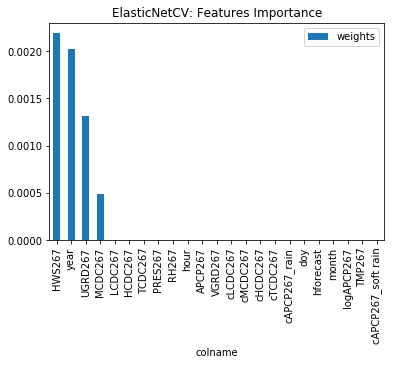

In [8]:
from sklearn.linear_model import ElasticNetCV

# regressor: ElasticNetCV (for tuning hyperparameters)
estimatorcv = ElasticNetCV(l1_ratio=[.0001, .001 , .1, .5, .7, .9, .95, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=False, precompute='auto', max_iter=5000, tol=0.0001, cv=ncv, 
                        copy_X=True, verbose=0, n_jobs=njobs, positive=False, random_state=None, selection='cyclic')
estimatorcv.fit(X_train, y_train)
print('- Optimal alpha: %.8f'%estimatorcv.alpha_)
print('- Optimal l1_ratio: %.3f'%estimatorcv.l1_ratio_)
print('- Number of iterations %d'%estimatorcv.n_iter_)
# plot features importance
import matplotlib.pyplot as plt
dfw = pd.DataFrame(np.c_[lcolx_new,np.array(estimatorcv.coef_)], columns = ['colname','weights']).sort_values(['weights'], ascending=[0]).set_index('colname')
dfw['weights'] = dfw['weights'].astype('float')
dfw.plot(kind='bar',title='ElasticNetCV: Features Importance')
plt.show()

## Sequential feature selection algorithms (Classification)

In [9]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

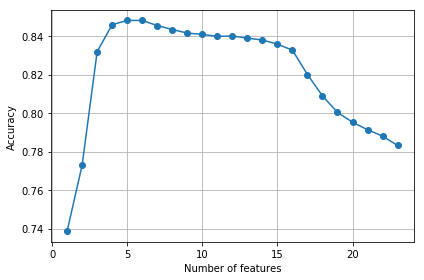

In [13]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X, cy)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
#plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
k3 = list(sbs.subsets_[18])
print(np.array(lcolx_new)[:][k3])

['hforecast' 'MCDC267' 'HCDC267' 'hour' 'doy']


In [20]:
knn.fit(X_train, cy_train)
print('Training accuracy:', knn.score(X_train, cy_train))
print('Test accuracy:', knn.score(X_test, cy_test))

Training accuracy: 0.843603648016
Test accuracy: 0.777532828525


In [21]:
knn.fit(X_train[:, k3], cy_train)
print('Training accuracy:', knn.score(X_train[:, k3], cy_train))
print('Test accuracy:', knn.score(X_test[:, k3], cy_test))

Training accuracy: 0.888217894996
Test accuracy: 0.842998178856


## Assessing feature importance with Random Forests (Classification)

 1) hforecast                      0.205670
 2) hour                           0.199834
 3) RH267                          0.063220
 4) TMP267                         0.058633
 5) doy                            0.055619
 6) VGRD267                        0.042861
 7) HWS267                         0.040308
 8) UGRD267                        0.039767
 9) PRES267                        0.038037
10) MCDC267                        0.035243
11) TCDC267                        0.032950
12) month                          0.031174
13) HCDC267                        0.023027
14) APCP267                        0.020773
15) logAPCP267                     0.020393
16) LCDC267                        0.018245
17) cMCDC267                       0.017693
18) year                           0.015435
19) cTCDC267                       0.014259
20) cHCDC267                       0.011201
21) cLCDC267                       0.008288
22) cAPCP267_soft rain             0.004399
23) cAPCP267_rain               

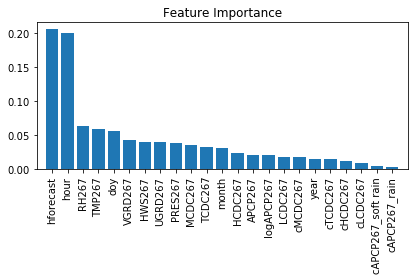

In [22]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = np.array(lcolx_new)

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1, n_jobs = -1)

forest.fit(X_train, cy_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

## Assessing feature importance with Random Forests (Regression)

 1) UGRD267                        0.106370
 2) RH267                          0.103410
 3) PRES267                        0.102683
 4) TMP267                         0.097877
 5) HWS267                         0.086810
 6) VGRD267                        0.086466
 7) doy                            0.058515
 8) TCDC267                        0.049793
 9) MCDC267                        0.043415
10) hour                           0.040477
11) HCDC267                        0.039873
12) hforecast                      0.038087
13) LCDC267                        0.035117
14) APCP267                        0.024056
15) logAPCP267                     0.023890
16) year                           0.018240
17) month                          0.010760
18) cHCDC267                       0.007427
19) cTCDC267                       0.007245
20) cMCDC267                       0.006662
21) cLCDC267                       0.006204
22) cAPCP267_soft rain             0.005065
23) cAPCP267_rain               

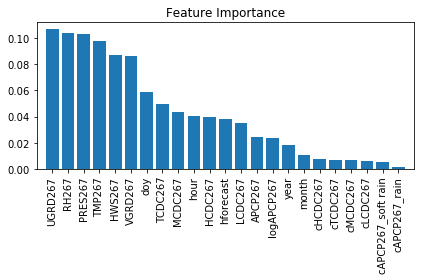

In [23]:
from sklearn.ensemble import RandomForestRegressor

feat_labels = np.array(lcolx_new)

forest = RandomForestRegressor(n_estimators=500,
                                random_state=1, n_jobs = -1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

## Using theBuilt-in XGBoost Feature Importance Plot (Classification)

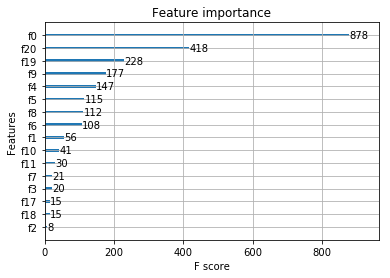

               colname            importance
id                                          
0            hforecast    0.3675177991390228
20                 doy   0.17496860027313232
19                hour    0.0954374223947525
9               TMP267   0.07408957928419113
4              MCDC267  0.061532020568847656
5              HCDC267   0.04813729599118233
8                RH267    0.0468815416097641
6              TCDC267  0.045207198709249496
1              VGRD267   0.02344077080488205
10             APCP267   0.01716199330985546
11              HWS267  0.012557555921375751
7              PRES267  0.008790289051830769
3              LCDC267  0.008371703326702118
17                year  0.006278777960687876
18               month  0.006278777960687876
2              UGRD267  0.003348681377246976
12            cLCDC267                   0.0
13            cMCDC267                   0.0
14            cHCDC267                   0.0
15            cTCDC267                   0.0
16        

In [24]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# fit model no training data
model = XGBClassifier()
model.fit(X_train, cy_train)
# plot feature importance
plot_importance(model)
pyplot.show()
# importance df
dfimportance = pd.DataFrame(np.c_[np.arange(len(lcolx_new)),np.array(lcolx_new),model.feature_importances_],columns=['id','colname','importance']).set_index('id').sort_values(['importance'], ascending=[0])
print(dfimportance)

In [25]:
model.fit(X_train, cy_train)
print('Training accuracy:', model.score(X_train, cy_train))
print('Test accuracy:', model.score(X_test, cy_test))

Training accuracy: 0.845986361022
Test accuracy: 0.831592063644


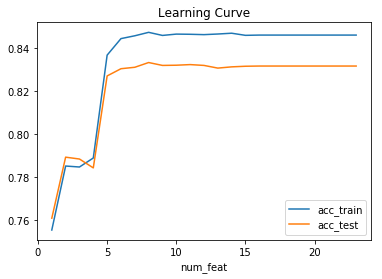

In [26]:
## LEARNING CURVE
lindex = [int(i) for i in dfimportance.index.tolist()]
lacc_train = list()
lacc_test = list()
for ii in list(range(1,len(lindex)+1,1)):
    model.fit(X_train[:,lindex[:ii]], cy_train)
    lacc_train.append(model.score(X_train[:,lindex[:ii]], cy_train))
    lacc_test.append(model.score(X_test[:,lindex[:ii]], cy_test))
dfacc = pd.DataFrame(list(zip(list(range(1,len(lindex)+1,1)), lacc_train, lacc_test)), columns = ['num_feat','acc_train','acc_test']).set_index('num_feat')
dfacc.plot(title="Learning Curve")

## Using theBuilt-in XGBoost Feature Importance Plot (Regression)

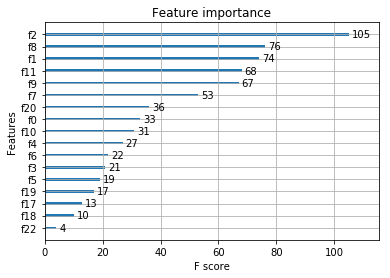

               colname            importance
id                                          
2              UGRD267   0.15532544255256653
8                RH267    0.1124260351061821
1              VGRD267   0.10946745425462723
11              HWS267   0.10059171915054321
9               TMP267   0.09911242872476578
7              PRES267   0.07840237021446228
20                 doy   0.05325443670153618
0            hforecast   0.04881656914949417
10             APCP267    0.0458579882979393
4              MCDC267   0.03994082659482956
6              TCDC267   0.03254437819123268
3              LCDC267  0.031065089628100395
5              HCDC267  0.028106508776545525
19                hour  0.025147929787635803
17                year   0.01923076994717121
18               month   0.01479289960116148
22  cAPCP267_soft rain  0.005917159840464592
12            cLCDC267                   0.0
13            cMCDC267                   0.0
14            cHCDC267                   0.0
15        

In [27]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
# fit model no training data
model = XGBRegressor()
model.fit(X_train, y_train)
# plot feature importance
plot_importance(model)
pyplot.show()
# importance df
dfimportance = pd.DataFrame(np.c_[np.arange(len(lcolx_new)),np.array(lcolx_new),model.feature_importances_],columns=['id','colname','importance']).set_index('id').sort_values(['importance'], ascending=[0])
print(dfimportance)

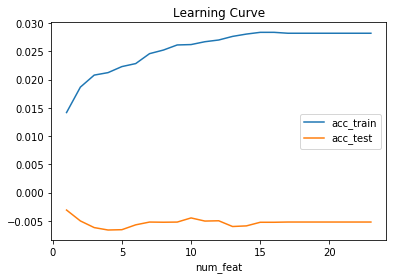

In [28]:
## LEARNING CURVE
lindex = [int(i) for i in dfimportance.index.tolist()]
lacc_train = list()
lacc_test = list()
for ii in list(range(1,len(lindex)+1,1)):
    model.fit(X_train[:,lindex[:ii]], y_train)
    lacc_train.append(model.score(X_train[:,lindex[:ii]], y_train))
    lacc_test.append(model.score(X_test[:,lindex[:ii]], y_test))
dfacc = pd.DataFrame(list(zip(list(range(1,len(lindex)+1,1)), lacc_train, lacc_test)), columns = ['num_feat','acc_train','acc_test']).set_index('num_feat')
dfacc.plot(title="Learning Curve")